***Import Libraries***

In [1]:
"""This program bilinearizes 3R planar dyanmics using koopman theory and autoencoder to map"""
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools

import torch

# bilinear Koopman
from core.koopman_core import KoopDNN, KoopmanNet, KoopmanNetCtrl
from models.koop_model import model_matricies,lift

# forward map neural net
from core.neural_fwd_map import map_Net

# 2R dynamics and kinetics
from dynamics.robot_3R import dynamics_3R_data_gen, dynamics_3R, forward_kinematics_3R, forward_map_3R, Jacobian_3R

## import paths
from paths.paths import path_pars

***Simulation Parameters***

In [2]:
dt = 0.005 #time step
num_snaps = 1000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 6 # no. of states
num_inputs = 3 # no. of inputs

***Robot Parameters***

In [3]:
robot_pars = {}
# link lengths
robot_pars['a1'] = 0.33
robot_pars['a2'] = 0.33
robot_pars['a3'] = 0.33

#link masses
robot_pars['m1'] = 0.1
robot_pars['m2'] = 0.1
robot_pars['m3'] = 0.1

# link inertias
robot_pars['I1'] = 1
robot_pars['I2'] = 1
robot_pars['I3'] = 1

#position of CM
robot_pars['l1'] = 0.33/2
robot_pars['l2'] = 0.33/2
robot_pars['l3'] = 0.33/2

#dynamic friction coefficient
robot_pars['fd'] = 0.0


***Data Generation for 3R***

In [4]:
# Trajectories
X_end,X_full, U_full = dynamics_3R_data_gen(dt,num_traj, num_snaps,num_states,num_inputs,robot_pars)
print(X_end.shape, X_full.shape,U_full.shape)

(125, 1001, 2) (125, 1001, 6) (125, 1000, 3)


In [5]:
X_full.T.shape, X_full.dtype

((6, 1001, 125), dtype('float64'))

***Plotting the trajectories***

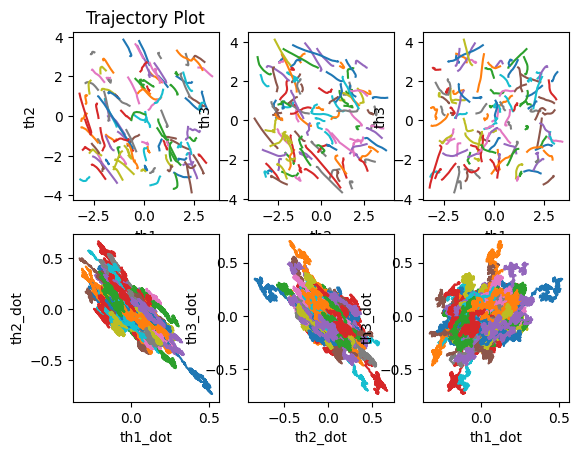

In [6]:
"""Training dataset visualization"""
#theta1 theta2 plot
plt.subplot(2,3,1)
plt.title("Trajectory Plot")
plt.xlabel("th1")
plt.ylabel("th2")
for i in range(num_traj):
  plt.plot(X_full[i,:,0],X_full[i,:,1])

#theta2 theta3 plot
plt.subplot(2,3,2)
plt.xlabel("th2")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,1],X_full[i,:,2])

#theta1 theta3 plot
plt.subplot(2,3,3)
plt.xlabel("th1")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,0],X_full[i,:,2])

#theta1_dot theta2_dot plot
plt.subplot(2,3,4)
plt.xlabel("th1_dot")
plt.ylabel("th2_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,4])

#theta2_dot theta3_dot plot
plt.subplot(2,3,5)
plt.xlabel("th2_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,4],X_full[i,:,5])

#theta1_dot theta3_dot plot
plt.subplot(2,3,6)
plt.xlabel("th1_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,5])



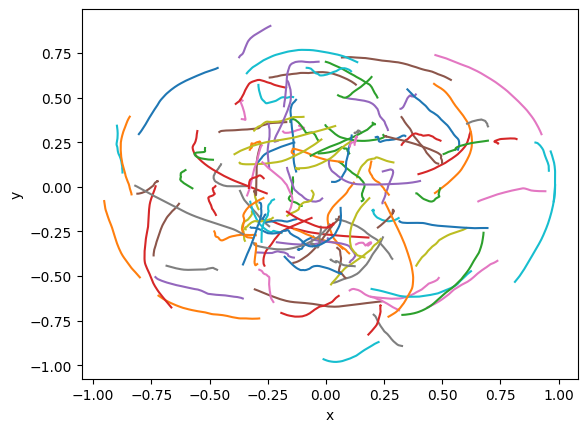

In [7]:
#x and y positions of the end effector

plt.xlabel("x")
plt.ylabel("y")
for i in range(num_traj):
    plt.plot(X_end[i,:,0],X_end[i,:,1])

***Training and validation datasets***

In [8]:
# split training and vaidation datasets
xs_train, us_train = X_full[:num_train,:,:],U_full[:num_train,:,:]
xs_val, us_val = X_full[num_train:,:,:],U_full[num_train:,:,:]

In [9]:
# import scipy.io
# Data_set = {"x_end": X_end, "X_full": X_full}
# scipy.io.savemat("Data_set.mat",Data_set)

In [10]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

***Model Training***

In [11]:
net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 40
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 15
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 4e-4 # 5e-4
net_params['epochs'] = 100
net_params['batch_size'] = 128
net_params['lifted_loss_penalty'] = 0.4 
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifetd state
net_params['dt'] = dt

In [12]:
train = True

if train == True:
    file = 'saved_models/3R/bilinear/koop_arch.pth'
    net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    file = 'saved_models/3R/koop_arch.pth'
    model_koop_dnn = torch.load(file)


Epoch   1: train loss: 0.3765917420, validation loss: 0.1361721734
Epoch   2: train loss: 0.0351453535, validation loss: 0.0072190174
Epoch   3: train loss: 0.0028933324, validation loss: 0.0014601973
Epoch   4: train loss: 0.0011262901, validation loss: 0.0008489693
Epoch   5: train loss: 0.0006545758, validation loss: 0.0005571419
Epoch   6: train loss: 0.0004260076, validation loss: 0.0003780354
Epoch   7: train loss: 0.0003000969, validation loss: 0.0003002703
Epoch   8: train loss: 0.0002258541, validation loss: 0.0002268186
Epoch   9: train loss: 0.0001810988, validation loss: 0.0002096550
Epoch  10: train loss: 0.0001529165, validation loss: 0.0001665896
Epoch  11: train loss: 0.0001335406, validation loss: 0.0001540467
Epoch  12: train loss: 0.0001187368, validation loss: 0.0001413891
Epoch  13: train loss: 0.0001106258, validation loss: 0.0001409467
Epoch  14: train loss: 0.0001030119, validation loss: 0.0001229039
Epoch  15: train loss: 0.0000960942, validation loss: 0.000132

***Learning Curves***

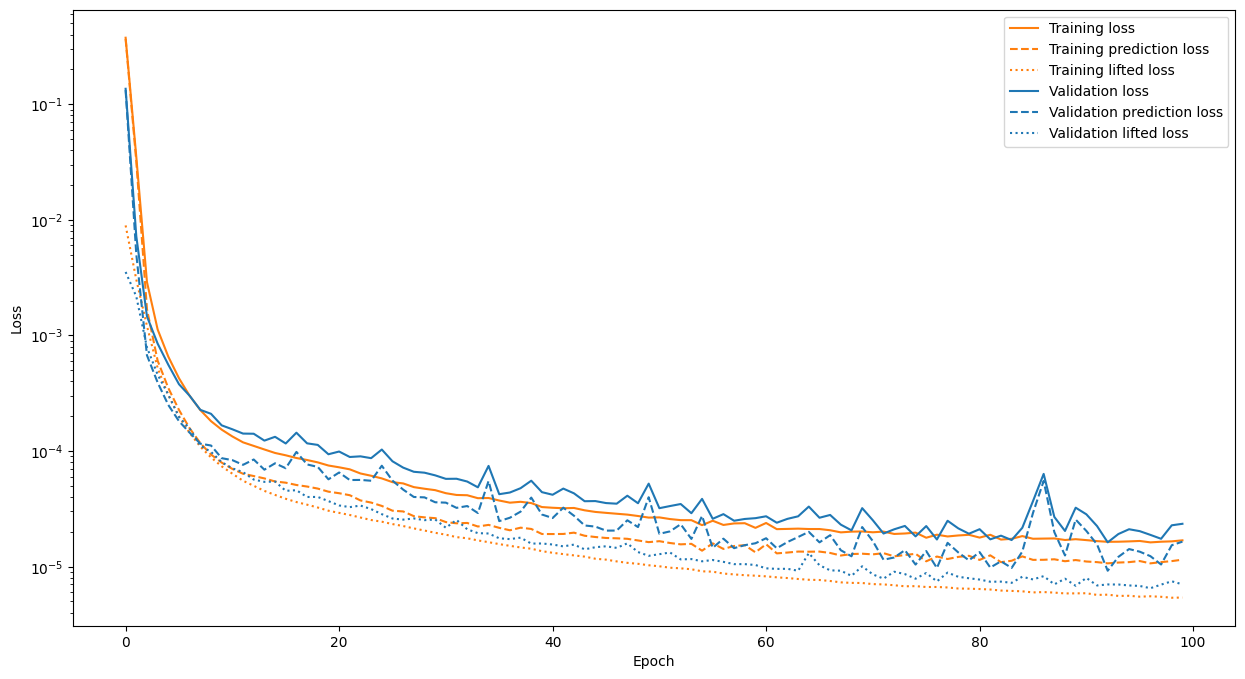

In [13]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot for arch1")
plt.show()


In [14]:
map_net_params = {}
map_net_params["input_dim"] = 3 #number of joint angles
map_net_params["output_dim"] = 2 #x and y position of the end effector
map_net_params["hidden_width"] = 20
map_net_params["hidden_depth"] = 2
map_net_params["batch_size"] = 200
map_net_params["epochs"] = 100
map_net_params["activation_type"] = 'tanh'
map_net_params["lr"] = 1e-3
map_net_params["optimizer"] = 'adam'
map_net_params['l2_reg'] = 0.0
map_net_params['l1_reg'] = 0.0

In [15]:
#dataset
# split training and vaidation datasets
xs_map_train, ys_map_train = X_full[:num_train,:,0:3],X_end[:num_train,:,:]
xs_map_val, ys_map_val = X_full[num_train:,:,0:3],X_end[num_train:,:,:]


In [16]:
ys_map_train.shape, ys_map_val.shape,xs_map_train.shape, xs_map_val.shape

((100, 1001, 2), (25, 1001, 2), (100, 1001, 3), (25, 1001, 3))

Epoch   1: train loss: 0.0520335297, validation loss: 0.0191154414
Epoch   2: train loss: 0.0113502592, validation loss: 0.0098969027
Epoch   3: train loss: 0.0053398977, validation loss: 0.0063880345
Epoch   4: train loss: 0.0027247295, validation loss: 0.0045152290
Epoch   5: train loss: 0.0015840325, validation loss: 0.0034862545
Epoch   6: train loss: 0.0011012104, validation loss: 0.0029631864
Epoch   7: train loss: 0.0008448718, validation loss: 0.0027131665
Epoch   8: train loss: 0.0006946217, validation loss: 0.0023564932
Epoch   9: train loss: 0.0005962223, validation loss: 0.0021689637
Epoch  10: train loss: 0.0005243953, validation loss: 0.0019872740
Epoch  11: train loss: 0.0004681889, validation loss: 0.0018960542
Epoch  12: train loss: 0.0004192264, validation loss: 0.0017529470
Epoch  13: train loss: 0.0003790375, validation loss: 0.0015074074
Epoch  14: train loss: 0.0003478684, validation loss: 0.0016390311
Epoch  15: train loss: 0.0003191552, validation loss: 0.001415

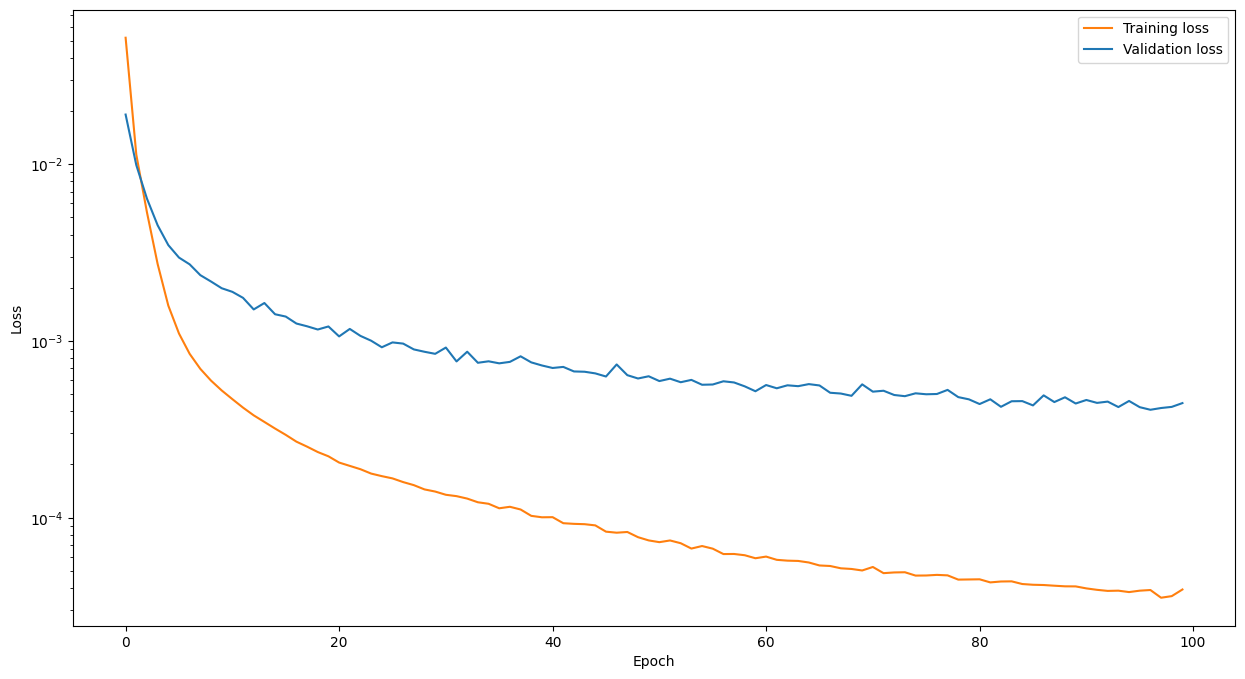

In [17]:
#Initalize network
train = True

if train==True:
    file = "saved_models/3R/map_net.pth"
    map_net = map_Net(map_net_params)
    map_net.set_dataset_map(xs_map_train,ys_map_train,xs_map_val,ys_map_val)
    map_net.data_pipeline()
    map_net.plot_loss()
    torch.save(map_net.state_dict(),file)
else:
    file = "saved_models/3R/map_net.pth"
    map_net = map_Net(map_net_params)
    map_net.load_state_dict(torch.load(file))


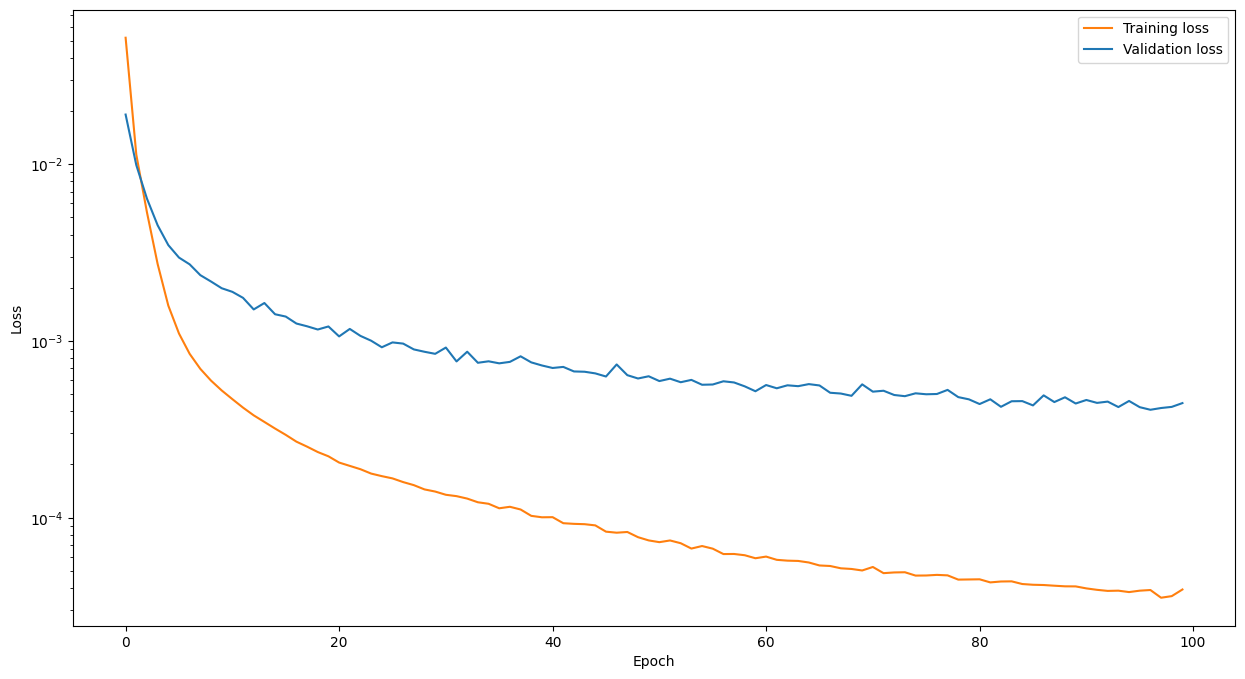

In [18]:
epochs = np.arange(0, map_net_params['epochs'])
plt.figure(figsize=(15,8))
plt.plot(epochs, map_net.train_loss_hist, color='tab:orange', label='Training loss')
plt.plot(epochs, map_net.val_loss_hist, color='tab:blue', label='Validation loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot of map net for arch1[3,20,20,2]")
plt.show()

In [19]:
# import scipy.io

# #save net parameters
# scipy.io.savemat("map_in_weights.mat", {"map_in_weights": map_net.map_net_in.weight.detach().numpy()})
# scipy.io.savemat("map_in_bias.mat", {"map_in_bias": map_net.map_net_in.bias.detach().numpy()})

# scipy.io.savemat("map_hidden_weights_1.mat",
#                  {"map_hidden_weights_1": map_net.map_net_hid[0].weight.detach().numpy()})
# scipy.io.savemat("map_hidden_bias_1.mat",
#                  {"map_hidden_bias_1": map_net.map_net_hid[0].bias.detach().numpy()})

# scipy.io.savemat("map_hidden_weights_2.mat",
#                  {"map_hidden_weights_2": map_net.map_net_hid[1].weight.detach().numpy()})
# scipy.io.savemat("map_hidden_bias_2.mat",
#                  {"map_hidden_bias_2": map_net.map_net_hid[1].bias.detach().numpy()})

# scipy.io.savemat("map_hidden_weights_3.mat",
#                  {"map_hidden_weights_3": map_net.map_net_hid[2].weight.detach().numpy()})
# scipy.io.savemat("map_hidden_bias_3.mat",
#                  {"map_hidden_bias_3": map_net.map_net_hid[2].bias.detach().numpy()})

# scipy.io.savemat("map_out_weights.mat", {"map_out_weights": map_net.map_net_out.weight.detach().numpy()})
# scipy.io.savemat("map_out_bias.mat", {"map_out_bias": map_net.map_net_out.bias.detach().numpy()})

## Test Data Parameters

In [20]:
# test data parameters
num_snaps_val = 2000 # no. of snapshots
T = np.linspace(0,num_snaps_val*dt, num_snaps_val+1)
num_traj_val = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

***Koopman Bilinear Model***


In [123]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

Ac = (A-np.eye(n_obs))/dt
Bc = B/dt
Cc = C
Cr = C[0:int(num_joints),:]

print(A.shape, B.shape, C.shape)

(22, 22) (22, 66) (6, 22)


In [124]:
# #SAVE MATRIX PARAMETERS AS MATLAB FILE
# import scipy.io

# dyn_matrices = {"A": A, "B": B, "C": C}
# scipy.io.savemat("dyn_mat.mat", dyn_matrices)
# #save encoder parameters
# scipy.io.savemat("in_weights.mat", {"encode_in_weights": model_koop_dnn.net.encoder_fc_in.weight.detach().numpy()})
# scipy.io.savemat("in_bias.mat", {"encode_in_bias": model_koop_dnn.net.encoder_fc_in.bias.detach().numpy()})

# scipy.io.savemat("hidden_weights_1.mat",
#                  {"encode_hidden_weights_1": model_koop_dnn.net.encoder_fc_hid[0].weight.detach().numpy()})
# scipy.io.savemat("hidden_bias_1.mat",
#                  {"encode_hidden_bias_1": model_koop_dnn.net.encoder_fc_hid[0].bias.detach().numpy()})

# scipy.io.savemat("hidden_weights_2.mat",
#                  {"encode_hidden_weights_2": model_koop_dnn.net.encoder_fc_hid[1].weight.detach().numpy()})
# scipy.io.savemat("hidden_bias_2.mat",
#                  {"encode_hidden_bias_2": model_koop_dnn.net.encoder_fc_hid[1].bias.detach().numpy()})

# scipy.io.savemat("out_weights.mat", {"encode_out_weights": model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()})
# scipy.io.savemat("out_bias.mat", {"encode_out_bias": model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()})

In [125]:
encode_out_bias = model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()
encode_out_weights = model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()

***Test Data Generation***

In [126]:
# data_gen
xs_end_test,xs_test, us_test = dynamics_3R_data_gen(dt,num_traj_val, num_snaps_val,num_states,num_inputs, robot_pars)

In [127]:
print(model_koop_dnn.test_loss(xs_test,u_test = us_test))

tensor(0.2747)


In [128]:
xs_end_test.shape

(1, 2001, 2)

In [129]:
basis = model_koop_dnn.net.encode_forward_

In [130]:
X,_ = model_koop_dnn.net.process(xs_test,data_u = us_test)
print(X.shape)

(2000, 15)


In [131]:
x = X[:, :num_states]
u = X[:, num_states:num_states+num_inputs]
x_prime = X[:,num_states+num_inputs:]

print(x.shape, u.shape, x_prime.shape)

(2000, 6) (2000, 3) (2000, 6)


***Initial Condition Lifting***

In [132]:
# initialize the matricies
z = np.empty((n_obs,num_snaps_val+1)).T
x_est = np.zeros((num_states,num_snaps_val+1)).T

In [133]:
z[0,:] = lift(x[0,:],model_koop_dnn, net_params)
x_est[0,:] = x[0,:]

***Time Evolution***

In [134]:
for i in range(num_snaps_val):
  #bilinear
    z[i+1,:] = np.matmul(z[i,:],A.T)+np.matmul(np.kron(u[i,:],z[i,:]),B.T)
    x_est[i+1,:] = np.matmul(z[i+1,:],C.T)     

In [135]:
# theta to end effector positions
# Function for dynamics
def cartesian_pos_gen_3R(th_data, robot_pars):
    #define parameters
    # link lengths
    a1 = robot_pars['a1']
    a2 = robot_pars['a2']
    a3 = robot_pars['a3']
    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    m3 = robot_pars['m3']
    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I2']
    I3 = robot_pars['I3']
    #position of CM
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    l3 = robot_pars['l3']

    
    # X  = rows are joint and effector positions and velocities
    num_states = 2*th_data.shape[1]
    num_snaps = th_data.shape[0]
    X = np.empty((num_snaps,num_states)) # cartesian state matrix

    for i in range(num_snaps):
        # time evolution
        X[i,0] = a1*np.cos(th_data[i,0]) + a2*np.cos(th_data[i,0]+th_data[i,1])+a3*np.cos(th_data[i,0]+th_data[i,1]+th_data[i,2]) # end_eff_x
        X[i,1] = a1*np.sin(th_data[i,0]) + a2*np.sin(th_data[i,0]+th_data[i,1])+a3*np.sin(th_data[i,0]+th_data[i,1]+th_data[i,2]) # end_eff_y
        X[i,2] = a1*np.cos(th_data[i,0]) + a2*np.cos(th_data[i,0]+th_data[i,1]) # jt2_x
        X[i,3] = l1*np.sin(th_data[i,0]) + l2*np.sin(th_data[i,0]+th_data[i,1]) # jt2_y
        X[i,4] = l1*np.cos(th_data[i,0]) #jt1_x
        X[i,5] = l1*np.sin(th_data[i,0]) #jt1_y

        #joint velocities
        X[i,6] = -a1*np.sin(th_data[i,0])*th_data[i,3] - a2*np.sin(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4])-a3*np.sin(th_data[i,0]+th_data[i,1]+th_data[i,2])*(th_data[i,3]+th_data[i,4]+th_data[i,5]) # end_eff_x
        X[i,7] = a1*np.cos(th_data[i,0])*th_data[i,3] + a2*np.cos(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4])+a3*np.cos(th_data[i,0]+th_data[i,1]+th_data[i,2])*(th_data[i,3]+th_data[i,4]+th_data[i,5]) # end_eff_y
        X[i,8] = -a1*np.sin(th_data[i,0])*th_data[i,3] - a2*np.sin(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4]) # end_eff_x
        X[i,9] = a1*np.cos(th_data[i,0])*th_data[i,3] + a2*np.cos(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4]) # end_eff_y
        X[i,10] = -a1*np.sin(th_data[i,0])*th_data[i,3] #jt_x
        X[i,11] = a1*np.cos(th_data[i,0])*th_data[i,3] #jt_y
    return X

# Cartesian Positions

In [136]:
x_cart = cartesian_pos_gen_3R(x, robot_pars)
x_cart_est = cartesian_pos_gen_3R(x_est, robot_pars)

***Visualization***

# Joint Space

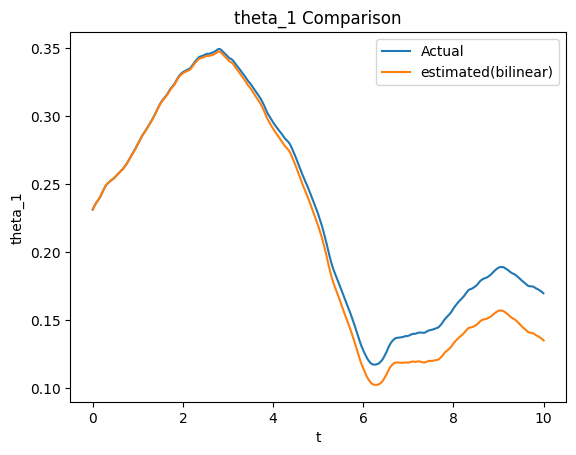

In [137]:
plt.figure()
plt.plot(T[:-1],x[:,0],label ='Actual')
plt.plot(T,x_est[:,0],label = 'estimated(bilinear)')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

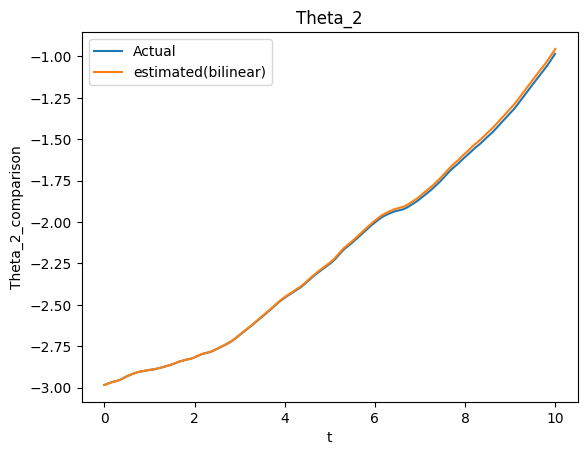

In [138]:
plt.figure()
plt.plot(T[:-1],x[:,1],label ='Actual')
plt.plot(T,x_est[:,1],label = 'estimated(bilinear)')
plt.title('Theta_2')
plt.xlabel('t')
plt.ylabel('Theta_2_comparison')
plt.legend()

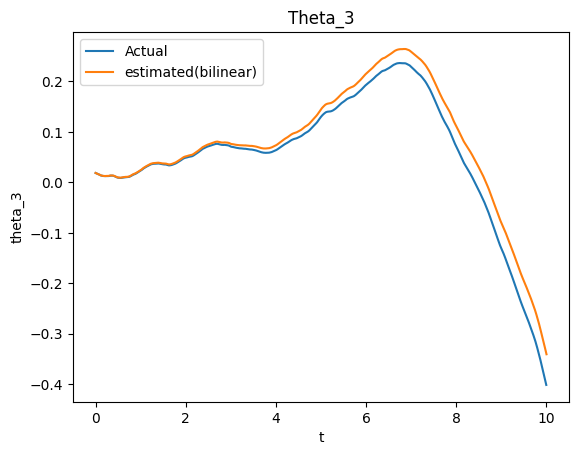

In [139]:

plt.figure()
plt.plot(T[:-1],x[:,2],label ='Actual')
plt.plot(T,x_est[:,2],label = 'estimated(bilinear)')
plt.title('Theta_3')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.legend()

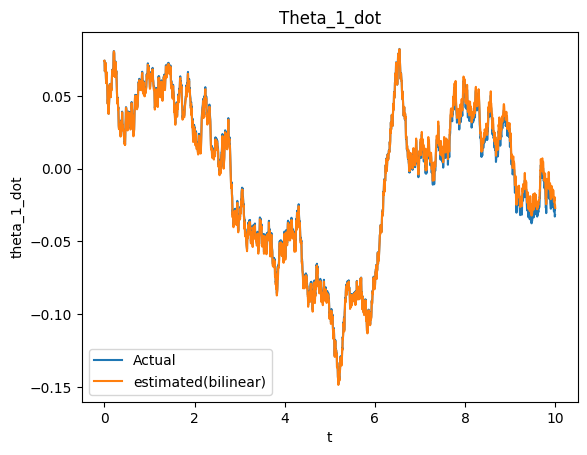

In [140]:
plt.figure()
plt.plot(T[:-1],x[:,3],label ='Actual')
plt.plot(T,x_est[:,3],label = 'estimated(bilinear)')
plt.title('Theta_1_dot')
plt.xlabel('t')
plt.ylabel('theta_1_dot')
plt.legend()

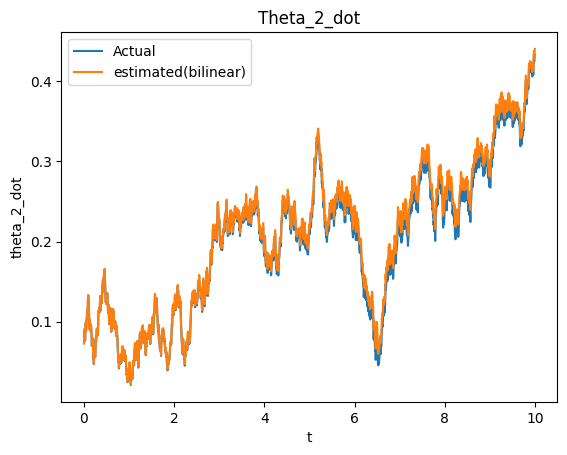

In [141]:
plt.figure()
plt.plot(T[:-1],x[:,4],label ='Actual')
plt.plot(T,x_est[:,4],label = 'estimated(bilinear)')
plt.title('Theta_2_dot')
plt.xlabel('t')
plt.ylabel('theta_2_dot')
plt.legend()

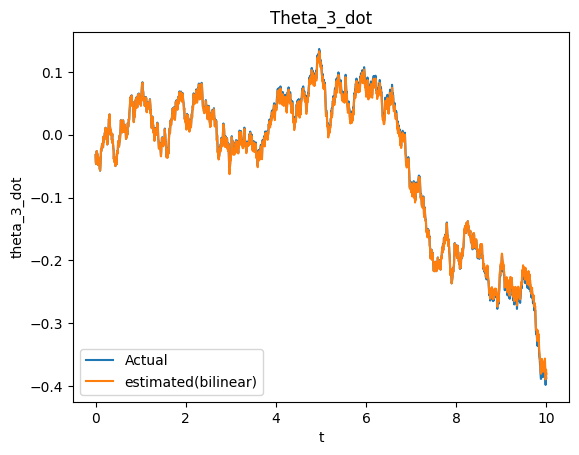

In [142]:
plt.figure()
plt.plot(T[:-1],x[:,5],label ='Actual')
plt.plot(T,x_est[:,5],label = 'estimated(bilinear)')
plt.title('Theta_3_dot')
plt.xlabel('t')
plt.ylabel('theta_3_dot')
plt.legend()

# Cartesian Space

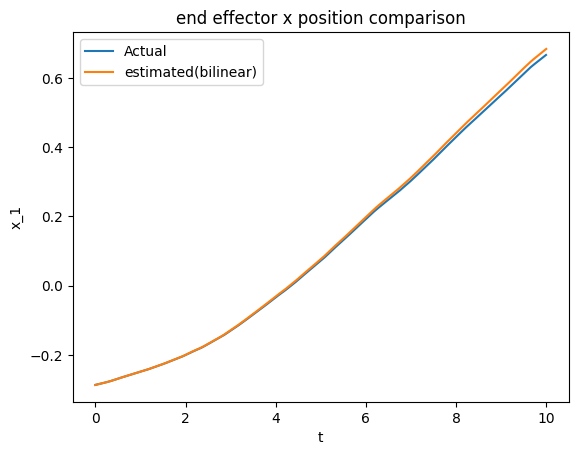

In [143]:
plt.figure()
plt.plot(T[:-1],x_cart[:,0],label ='Actual')
plt.plot(T[:],x_cart_est[:,0],label = 'estimated(bilinear)')
plt.title('end effector x position comparison')
plt.xlabel('t')
plt.ylabel('x_1')
plt.legend()

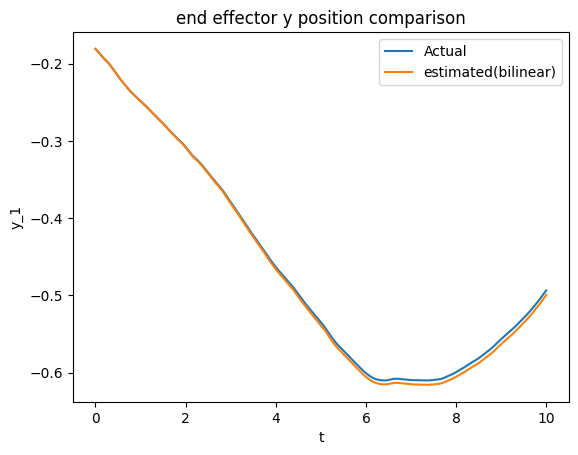

In [144]:
plt.figure()
plt.plot(T[:-1],x_cart[:,1],label ='Actual')
plt.plot(T[:],x_cart_est[:,1],label = 'estimated(bilinear)')
plt.title('end effector y position comparison')
plt.xlabel('t')
plt.ylabel('y_1')
plt.legend()

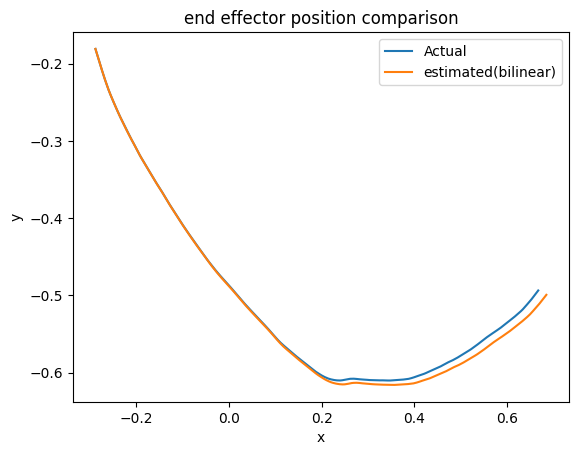

In [145]:
plt.figure()
plt.plot(x_cart[:,0],x_cart[:,1],label ='Actual')
plt.plot(x_cart_est[:,0],x_cart_est[:,1],label = 'estimated(bilinear)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('end effector position comparison')
plt.legend()

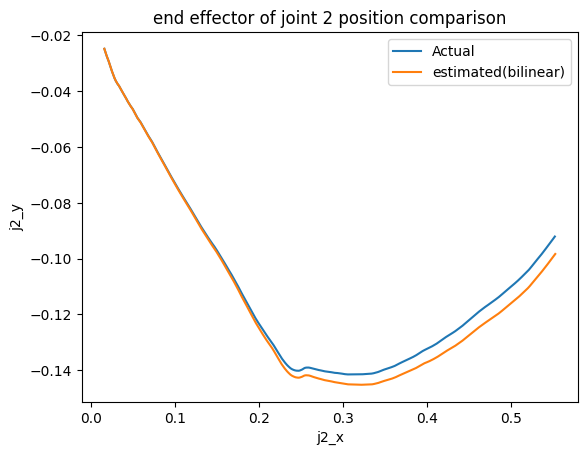

In [146]:
plt.figure()
plt.plot(x_cart[:,2],x_cart[:,3],label ='Actual')
plt.plot(x_cart_est[:,2],x_cart_est[:,3],label = 'estimated(bilinear)')
plt.xlabel('j2_x')
plt.ylabel('j2_y')
plt.title('end effector of joint 2 position comparison')
plt.legend()

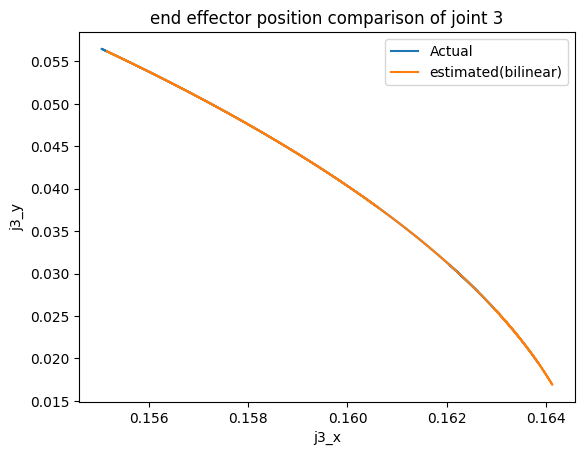

In [147]:
plt.figure()
plt.plot(x_cart[:,4],x_cart[:,5],label ='Actual')
plt.plot(x_cart_est[:,4],x_cart_est[:,5],label = 'estimated(bilinear)')
plt.xlabel('j3_x')
plt.ylabel('j3_y')
plt.title('end effector position comparison of joint 3')
plt.legend()

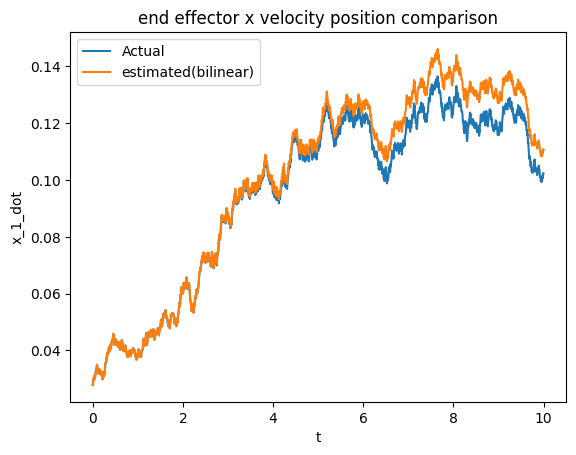

In [148]:
plt.figure()
plt.plot(T[:-1],x_cart[:,6],label ='Actual')
plt.plot(T[:],x_cart_est[:,6],label = 'estimated(bilinear)')
plt.title('end effector x velocity position comparison')
plt.xlabel('t')
plt.ylabel('x_1_dot')
plt.legend()

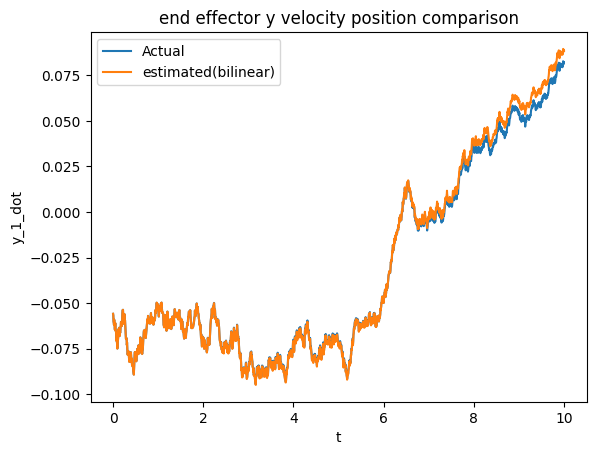

In [149]:
plt.figure()
plt.plot(T[:-1],x_cart[:,7],label ='Actual')
plt.plot(T[:],x_cart_est[:,7],label = 'estimated(bilinear)')
plt.title('end effector y velocity position comparison')
plt.xlabel('t')
plt.ylabel('y_1_dot')
plt.legend()

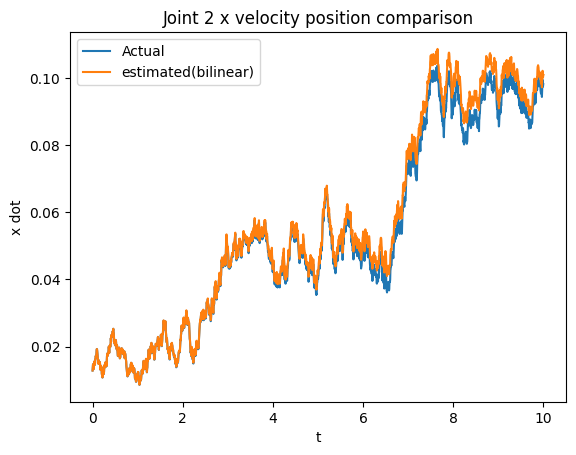

In [150]:
plt.figure()
plt.plot(T[:-1],x_cart[:,8],label ='Actual')
plt.plot(T[:],x_cart_est[:,8],label = 'estimated(bilinear)')
plt.title('Joint 2 x velocity position comparison')
plt.xlabel('t')
plt.ylabel('x dot')
plt.legend()

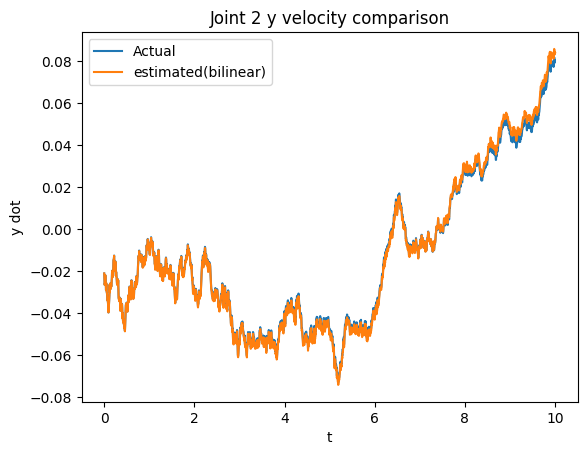

In [151]:
plt.figure()
plt.plot(T[:-1],x_cart[:,9],label ='Actual')
plt.plot(T[:],x_cart_est[:,9],label = 'estimated(bilinear)')
plt.title('Joint 2 y velocity comparison')
plt.xlabel('t')
plt.ylabel('y dot')
plt.legend()

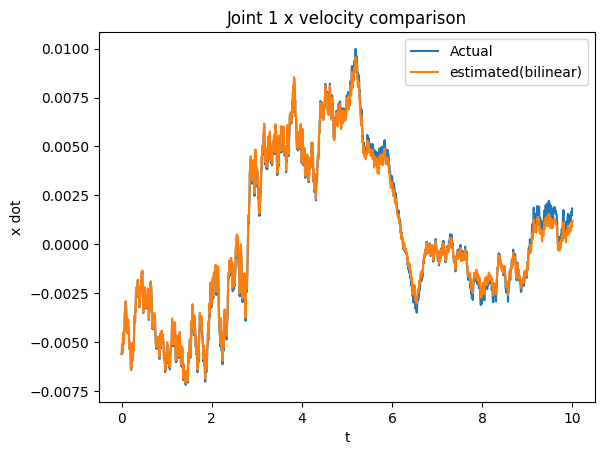

In [152]:
plt.figure()
plt.plot(T[:-1],x_cart[:,10],label ='Actual')
plt.plot(T[:],x_cart_est[:,10],label = 'estimated(bilinear)')
plt.title('Joint 1 x velocity comparison')
plt.xlabel('t')
plt.ylabel('x dot')
plt.legend()

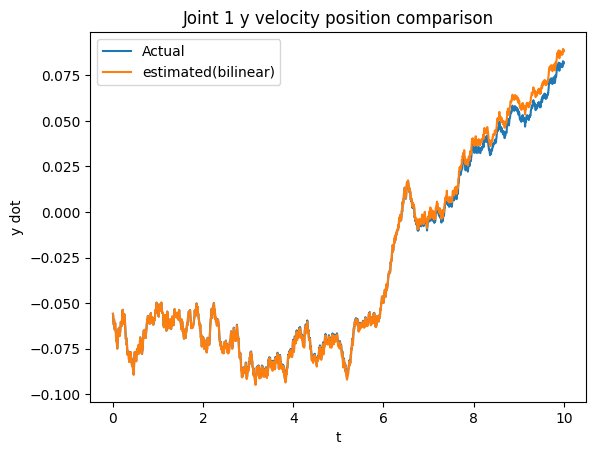

In [153]:
plt.figure()
plt.plot(T[:-1],x_cart[:,7],label ='Actual')
plt.plot(T[:],x_cart_est[:,7],label = 'estimated(bilinear)')
plt.title('Joint 1 y velocity position comparison')
plt.xlabel('t')
plt.ylabel('y dot')
plt.legend()

In [154]:
# data_gen
xs_end_test,xs_test, us_test = dynamics_3R_data_gen(dt,num_traj_val, num_snaps_val,num_states,num_inputs,robot_pars)

In [155]:
#testing the map network
theta_test = xs_test[:,:,0:3]
theta_test = theta_test.T.reshape((3,2001),order='F')
theta_test = theta_test.T
x_end_pred = np.empty((num_snaps_val+1,2))

In [156]:
for i in range(num_snaps_val):
    th_t = torch.from_numpy(theta_test[i,:]).float()
    x_end_pred[i,:] = map_net(th_t).detach().numpy()

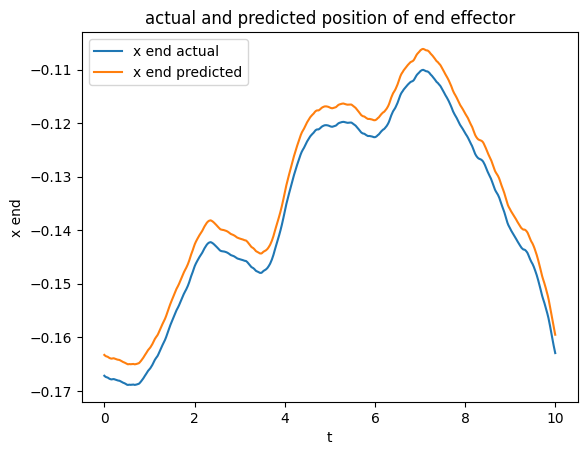

In [157]:

#plot
plt.figure()
plt.plot(T[:-1],xs_end_test[:,0:-1,0].T,label='x end actual')
plt.plot(T[:-1],x_end_pred[0:-1,0],label='x end predicted')
plt.xlabel('t')
plt.ylabel('x end')
plt.legend()
plt.title('actual and predicted position of end effector')
plt.show()

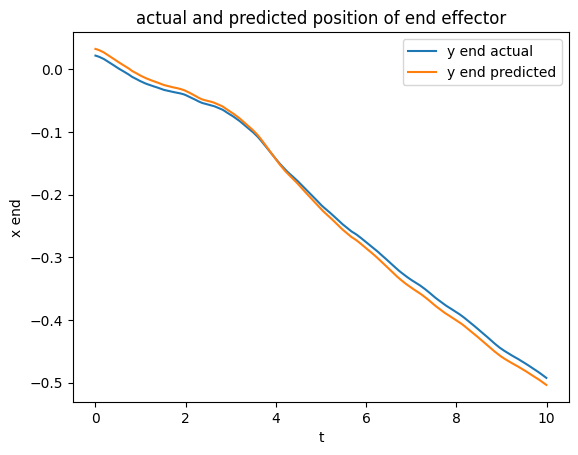

In [158]:
plt.figure()
plt.plot(T[:-1],xs_end_test[:,0:-1,1].T,label='y end actual')
plt.plot(T[:-1],x_end_pred[0:-1,1],label='y end predicted')
plt.xlabel('t')
plt.ylabel('x end')
plt.legend()
plt.title('actual and predicted position of end effector')
plt.show()

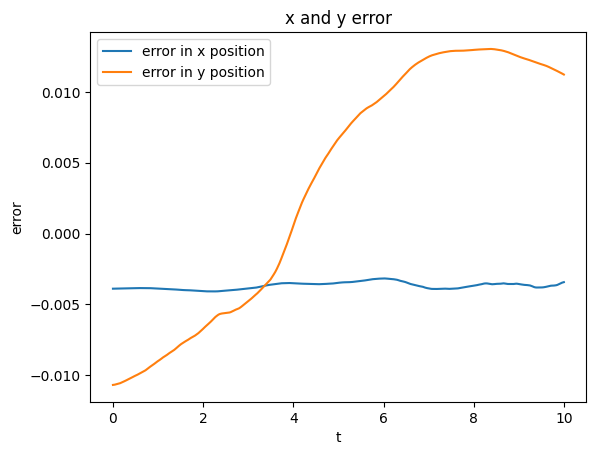

In [159]:
#error plot
plt.figure()
error_x = xs_end_test[:,0:-1,0]-x_end_pred[0:-1,0]
error_y = xs_end_test[:,0:-1,1]-x_end_pred[0:-1,1]
plt.plot(T[:-1],error_x.T,label='error in x position')
plt.plot(T[:-1],error_y.T,label='error in y position')
plt.xlabel('t')
plt.ylabel('error')
plt.legend()
plt.title('x and y error')
plt.show()

# Control of the bilinear model

## Controllers

## Reference Trajectory

In [160]:
t_ctrl = np.arange(start=0, stop=5, step=dt)
num_snaps_ctrl = t_ctrl.shape[0]

In [161]:
## linear path
# x_ref = np.vstack((np.vstack((np.linspace(0,np.pi,num_snaps_ctrl),np.linspace(0,np.pi/2,num_snaps_ctrl))),np.linspace(0,np.pi,num_snaps_ctrl)))
# x_ref_dot = np.vstack((np.vstack(((np.pi/10)*np.ones(num_snaps_ctrl),(np.pi/20)*np.ones(num_snaps_ctrl))),(np.pi/10)*np.ones(num_snaps_ctrl)))
# x_ref_ddot = np.vstack((np.vstack((np.zeros(num_snaps_ctrl),np.zeros(num_snaps_ctrl))),np.zeros(num_snaps_ctrl)))

def gen_desired_path(num_states,num_snaps, t_end,shape):
    
    x_ref = np.empty((int(num_states),num_snaps))
    x_ref_dot = np.empty_like(x_ref)
    x_ref_ddot = np.empty_like(x_ref)
    
    arg = np.linspace(0,np.pi,num_snaps)
    
    for i in range(num_snaps):
        if shape == 'linear':
            x_ref[:,i] = np.array([arg[i], arg[i]/2, arg[i]])
            x_ref_dot[:,i] = np.array([arg[-1]/t_end, arg[-1]/(2*t_end), arg[-1]/(t_end)])
            x_ref_ddot[:,i] = np.zeros(num_states,)
            
        elif shape == 'sinosoidal':
            x_ref[:,i] = 0.1*np.array([np.sin(2*arg[i]),np.sin(2*arg[i]) , np.sin(2*arg[i])])
            x_ref_dot[:,i] = 0.1*np.array([(2*arg[-1]/t_end)*np.cos(2*arg[i]),(2*arg[-1]/t_end)*np.cos(2*arg[i]),
                                      (2*arg[-1]/t_end)*np.cos(2*arg[i])])
            x_ref_ddot[:,i] = 0.1* np.array([-((2*arg[-1]/t_end)**2)*np.cos(2*arg[i]),-((2*arg[-1]/t_end)**2)*np.sin(2*arg[i]),
                                      -((2*arg[-1]/t_end)**2)*np.sin(2*arg[i])])
        else:
            print('Shape is not defined')
            break
            
            
    return x_ref, x_ref_dot, x_ref_ddot



In [162]:
x_ref, x_ref_dot, x_ref_ddot = gen_desired_path(int(num_states/2),num_snaps_ctrl, t_ctrl[-1],'sinosoidal')
# x_ref = x[:,:3].T
# x_ref_dot = x[:,3:].T

## ZNN

In [163]:
# gamma = 10

In [164]:
# ## specify the matricies
# z_ctrl = np.empty((n_obs,num_snaps_ctrl))
# x_ctrl = np.empty((num_states,num_snaps_ctrl))
# u_ctrl = np.empty((num_inputs,num_snaps_ctrl-1))
#
# ## initialize the matricies
# x_ctrl[:,0] = np.hstack((x_ref[:,0],x_ref_dot[:,0]))
# z_ctrl[:,0] = lift(x_ctrl[:,0],model_koop_dnn, net_params)

In [165]:
# x_ref_full = np.vstack((x_ref,x_ref_dot))
# x_ref_dot_full = np.vstack((x_ref_dot,x_ref_ddot))
# for i in range(2):
#     t = t_ctrl[i]
#     u_ctrl[:,i] = np.dot(np.linalg.pinv(np.matmul(C,np.matmul(Bc, np.kron(z_ctrl[:,i],np.eye(num_inputs)).T))), -np.matmul(C,np.matmul(Ac,z_ctrl[:,i])) + x_ref_dot_full[:,i] - gamma*(x_ctrl[:,i] - x_ref_full[:,i]))
#
#     z_ctrl[:,i+1] = np.matmul(z_ctrl[:,i],A.T)+np.matmul(np.kron(u_ctrl[:,i],z_ctrl[:,i]),B.T)
#     x_ctrl[:,i+1] = np.matmul(z_ctrl[:,i+1],C.T)
#     # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
#     # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
#

In [166]:
# plt.figure(figsize=(20,12))
# for i in range(int(num_joints)):
#     plt.subplot(3,3,i+1)
#     plt.plot(t_ctrl[:400],x_ref[i,:400],label ='reference')
#     plt.plot(t_ctrl[:400],x_ctrl[i,:400],label = 'traced')
#     plt.xlabel('t')
#     plt.ylabel('theta_' + str(i))
#     plt.title('theta_' + str(i) + ' Comparison')
#     plt.legend()

In [167]:
# plt.figure(figsize=(20,12))
# for i in range(int(num_joints)):
#     plt.subplot(3,3,i+1)
#     plt.plot(t_ctrl[:],x_ref_dot[i,:],label ='reference')
#     plt.plot(t_ctrl[:],x_ctrl[int(i+num_joints),:],label = 'traced')
#     plt.xlabel('t')
#     plt.ylabel('theta_dot ' + str(i))
#     plt.title('theta_dot ' + str(i) + ' Comparison')
#     plt.legend()

In [168]:
# plt.figure(figsize=(20,12))
# for i in range(int(num_joints)):
#     plt.subplot(3,3,i+1)
#     plt.plot(t_ctrl[:-1],u_ctrl2[i,:])
#     plt.xlabel('t')
#     plt.ylabel('tau' + str(i))

In [169]:
# np.linalg.pinv(np.matmul(C,np.matmul(Bc, np.kron(z_ctrl[:,i],np.eye(num_inputs)).T))).shape

In [170]:
# np.dot(np.linalg.pinv(np.matmul(C,np.matmul(Bc, np.kron(z_ctrl[:,i],np.eye(num_inputs)).T))), -np.matmul(C,np.matmul(Ac,z_ctrl[:,i])) + x_ref_dot_full[:,i] - gamma*(x_ctrl[:,i] - x_ref_full[:,i])).shape

In [171]:
# ZNN implementation with only reference joint angles
num_joints = 3
gamma2 = 5
num_theta = int(num_joints)
# num_snaps_ctrl = 2
## specify the matricies
z_ctrl2 = np.empty((n_obs, num_snaps_ctrl))
x_ctrl2 = np.empty((num_theta, num_snaps_ctrl))
u_ctrl2 = np.empty((num_inputs, num_snaps_ctrl - 1))
error = np.zeros((num_theta, num_snaps_ctrl))

## initialize the matricies
x_ctrl2[:, 0] = x_ref[:, 0]
z_ctrl2[:, 0] = lift(np.hstack((x_ref[:, 0], x_ref_dot[:, 0])), model_koop_dnn, net_params)

for i in range(num_snaps_ctrl - 1):
    t = t_ctrl[i]
    error[:,i] = x_ctrl2[:,i] - x_ref[:,i]

    u_ctrl2[:,i] = np.linalg.pinv(Cr @ Bc @ np.kron(z_ctrl2[:, i], np.eye(num_inputs)).T) @ (-gamma2 * error[:,i] + x_ref_dot[:,i] - Cr @ Ac @ z_ctrl2[:,i])

    z_ctrl2[:, i + 1] = np.matmul(z_ctrl2[:, i], A.T) + np.matmul(np.kron(u_ctrl2[:, i], z_ctrl2[:, i]), B.T)
    x_ctrl2[:, i + 1] = np.matmul(z_ctrl2[:, i + 1], Cr.T)
    # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
    # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)


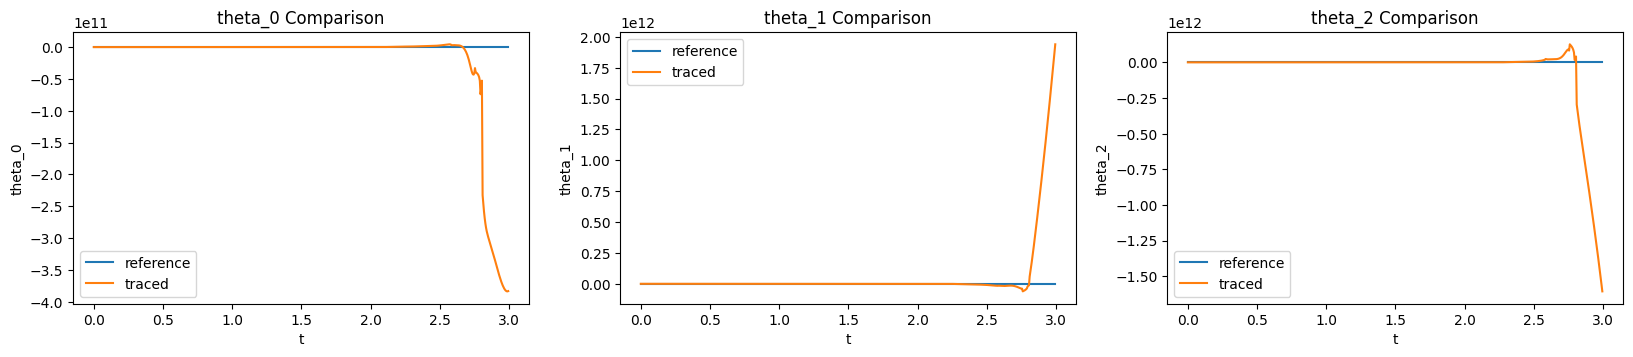

In [172]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:600],x_ref[i,:600],label ='reference')
    plt.plot(t_ctrl[:600],x_ctrl2[i,:600],label = 'traced')
    plt.xlabel('t')
    plt.ylabel('theta_' + str(i))
    plt.title('theta_' + str(i) + ' Comparison')
    plt.legend()

In [ ]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],u_ctrl2[i,:])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

In [ ]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl,error[i,:])
    plt.xlabel('t')
    plt.ylabel('error' + str(i))

## MPC